GAN ( Generative adverserial network)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


In [7]:
#Load in the data
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

# map inputs to (-1,+1) for better training 
x_train, x_test =x_train/255.0 *2 -1 ,x_test/255.0 *2 -1
print("x_train.shape: ",x_train.shape)

x_train.shape:  (60000, 28, 28)


In [8]:
#Flattening the data
N, H, W =x_train.shape
D=H*W
x_train=x_train.reshape(-1,D)
x_test=x_test.reshape(-1,D)

#Dimensionality of the latent space
latent_dim=100

#Get the generator model
def build_generator(latent_dim):
  i=Input(shape=(latent_dim,))
  x=Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(D,activation='tanh')(x)
  model=Model(i,x)
  return model

#Get the discriminator model
def build_discriminator(img_size):
  i=Input(shape=(img_size))
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x=Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x=Dense(1,activation='sigmoid')(x)
  model=Model(i,x)
  return model


In [9]:
#Compile both models in prepration of trainings
#Build and compile the discriminator
discriminator=build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002,0.5),
    metrics=['accuracy']
)

#Build and compile the combined model
generator =build_generator(latent_dim)

#Create and input to represent noise sample from the latent space
z=Input(shape=(latent_dim,))

#pass noise through generator to get and image
img =generator(z)

#make sure only generator is trained
discriminator.trainable =False

#the true output is fake but we label them real
fake_pred=discriminator(img)

#Create the combined model object
combined_model=Model(z,fake_pred)

#Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))



In [ ]:
#Train the GAN

#config
batch_size=32
epochs=30000
sample_period=200 #every sample_period step generate and save some data

#create batch labels to use when calling train on batch
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

#store the losses
d_losses=[]
g_losses=[]

#create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

#A function to generate grid of random samples from the generator and save them to a file
def save_images(epoch):
  rows,cols=5,5
  noise=np.random.randn(rows*cols,latent_dim)
  imgs=generator.predict(noise)
  #Rescale images 0-1
  imgs=0.5*imgs +0.5
  fig, axs=plt.subplots(rows,cols)
  idx=0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
      axs[i,j].axis('off')
      idx+=1
  fig.savefig('gan_images/%d.png'%epoch)
  plt.close()

#main training loop
for epoch in range(epochs):
  #training discriminator
  #select a random batch of images 
  idx=np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs=x_train[idx]
  #Generate fake images
  noise =np.random.randn(batch_size,latent_dim)
  fake_imgs=generator.predict(noise)
  #train the discriminator
  #both loss and accuracy are returned
  d_loss_real, d_acc_real= discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake, d_acc_fake=discriminator.train_on_batch(fake_imgs, zeros)
  d_loss=0.5*(d_loss_real+d_loss_fake)
  d_acc=0.5*(d_acc_real+d_acc_fake)
  #train generator
  noise=np.random.randn(batch_size,latent_dim)
  g_loss=combined_model.train_on_batch(noise,ones)
  #save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch %100 ==0:
    print(f'epoch:{epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc:{d_acc:.2f},g_loss: {g_loss:.2f}')
  
  if epoch %sample_period==0:
    save_images(epoch)
  
  plt.plot(g_losses, label='g_losses')
  plt.plot(d_losses,label='d_losses')
  plt.legend()


epoch:1/30000, d_loss: 0.79, d_acc:0.22,g_loss: 0.52
epoch:101/30000, d_loss: 0.01, d_acc:1.00,g_loss: 4.63
epoch:201/30000, d_loss: 0.05, d_acc:1.00,g_loss: 4.46
epoch:301/30000, d_loss: 0.16, d_acc:0.95,g_loss: 4.11
epoch:401/30000, d_loss: 0.70, d_acc:0.56,g_loss: 1.55
epoch:501/30000, d_loss: 0.66, d_acc:0.47,g_loss: 0.71
epoch:601/30000, d_loss: 0.63, d_acc:0.62,g_loss: 0.79
epoch:701/30000, d_loss: 0.70, d_acc:0.50,g_loss: 0.76
epoch:801/30000, d_loss: 0.64, d_acc:0.61,g_loss: 0.80
epoch:901/30000, d_loss: 0.66, d_acc:0.61,g_loss: 0.83
epoch:1001/30000, d_loss: 0.63, d_acc:0.66,g_loss: 0.86
epoch:1101/30000, d_loss: 0.57, d_acc:0.77,g_loss: 0.92
epoch:1201/30000, d_loss: 0.62, d_acc:0.61,g_loss: 0.87
epoch:1301/30000, d_loss: 0.59, d_acc:0.77,g_loss: 0.94
epoch:1401/30000, d_loss: 0.56, d_acc:0.78,g_loss: 0.88
epoch:1501/30000, d_loss: 0.56, d_acc:0.72,g_loss: 0.98
epoch:1601/30000, d_loss: 0.64, d_acc:0.59,g_loss: 1.05


0.png	  1200.png  1600.png  30000.png  600.png
1000.png  1400.png  200.png   400.png	 800.png


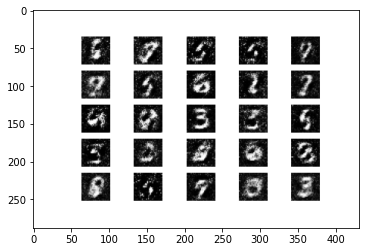

In [2]:
!ls gan_images

import matplotlib.pyplot as plt

from skimage.io import imread
a=imread('gan_images/1600.png')
plt.imshow(a)